In [273]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from timeit import default_timer as timer

## Basic Implementation

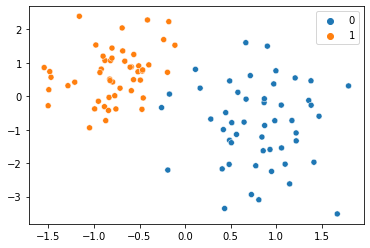

In [274]:
n_points = 100
X, y = make_classification(n_samples=n_points, n_features=2, n_informative=2, n_redundant=0, 
                           n_clusters_per_class=1, class_sep=0.75, random_state=8)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y)
plt.show()

In [275]:
## Compute distance between two vectors
def vectors_distance(vec1, vec2):
  _sum = 0
  n = len(vec1)
  for i in range(n):
    _sum += (vec1[i] - vec2[i])**2
  return np.sqrt(_sum)

In [276]:
## This function returns the class lable for a given query point 'x_q' and 'k'(# of nearest neighbors)
def pred_knn(x_q,k):
  N = len(X)
  distances = []
  ## Compute the distance from a query point to all other points
  for i in range(N):
    distances.append((vectors_distance(x_q, X[i]), y[i]))
  nn_points = sorted(distances, key=lambda x: x[0])[:k]    ## sort the distances from x_q to other points and get the top 'k' shortest distances 
  nn_y = [y_i[1] for y_i in nn_points]                    
  
  ## Count no. of pos and neg points around the query point 
  pos = 0; neg = 0
  for y_i in nn_y:
    if y_i:
      pos+=1
      continue
    neg +=1

  ## Do a marjory voting
  if pos>neg:
    return 1
  return 0

## Train a knn for a given 'k'
def knn(k):
  accuracy_count = 0
  missclassified_points = []; correct_points = []

  for i in range(N):
    y_hat = pred_knn(X[i],k)
    if y[i] == y_hat:
      accuracy_count+=1
      correct_points.append(X[i])
    else:
      missclassified_points.append(X[i])

  missclassified_points = np.array(missclassified_points)
  correct_points = np.array(correct_points)
  accuracy = accuracy_count/N
  error = 1-accuracy

  return accuracy, error, missclassified_points, correct_points


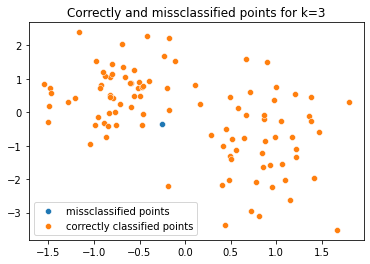

In [277]:
N = len(X)
accuracy_list = []
error_list = []
correct_points_list = []; missclassified_points_list = []

## For a given k find the missclassified points
k = 3
_, _, missclassified_points, correct_points = knn(k)

plt.title(f"Correctly and missclassified points for k={k}")
sns.scatterplot(x=missclassified_points[:,0], y=missclassified_points[:,1], label="missclassified points")
sns.scatterplot(x=correct_points[:,0], y=correct_points[:,1], label="correctly classified points")
plt.show()

In [278]:

## Knn for multiple 'k's
N = len(X)
k_values = np.arange(1,n_points,2)
accuracy_list = []
error_list = []
correct_points_list = []; missclassified_points_list = []

start = timer()
for k in k_values:
  accuracy, error, missclassified_points, correct_points = knn(k)

  accuracy_list.append(accuracy)
  error_list.append(error)
  missclassified_points_list.append(missclassified_points)
  correct_points_list.append(correct_points)
stop = timer()

basic_imple_time = stop - start 
print(f"Execution time(basic) : {round(basic_imple_time,2)} sec")

Execution time(basic) : 2.35 sec


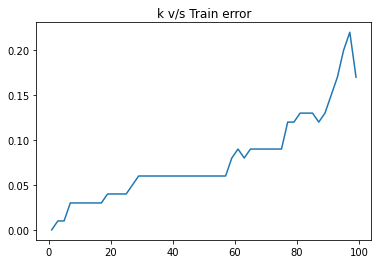

In [279]:
plt.title("k v/s Train error")
sns.lineplot(x=k_values, y=error_list)
plt.show()

* As the *`k`* increases the *`Train error`* also increases, that is the model *`underfits`* to the train data itself when *`k`* is large

## LSH implementation

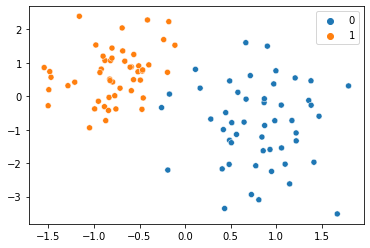

In [280]:
n_points = 100
X, y = make_classification(n_samples=n_points, n_features=2, n_informative=2, n_redundant=0, 
                           n_clusters_per_class=1, class_sep=0.75, random_state=8)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y)
plt.show()

In [281]:
## Compute distance between two vectors
def vectors_distance(vec1, vec2):
  _sum = 0
  n = len(vec1)
  for i in range(n):
    _sum += (vec1[i] - vec2[i])**2
  return np.sqrt(_sum)

In [282]:
def draw_line(coef,intercept, mi, ma):
    points=np.array([[((-coef[1]*mi - intercept)/coef[0]), mi],[((-coef[1]*ma - intercept)/coef[0]), ma]])
    return points[:,0], points[:,1]

In [283]:
n_weights = 3
weights_ = [ np.random.uniform(0,1,2) for i in range(n_weights) ]
weights = [w/vectors_distance([0,0], w) for w in weights_] ## getting the unit vectors
weights

[array([0.97025565, 0.24208256]),
 array([0.94619712, 0.32359081]),
 array([0.88821023, 0.45943726])]

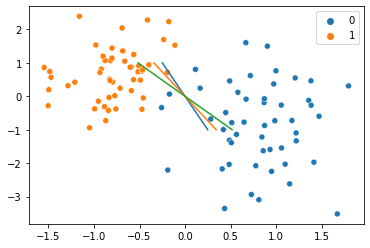

In [284]:
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y)
for w in weights:
  p_x, p_y = draw_line(w,0, -1, 1)
  sns.lineplot(x=p_x, y=p_y)
plt.show()

In [285]:
## Hash all the datapoints to their respective key locations by computing the hash function 
hash_table = {}

for i in range(n_points):
  key = ''
  for w in weights:
    ## defining the hash function; looks something like this (++---+)
    dist = np.dot(w,X[i]) 
    if dist>=0:
      key += '+'
    else:
      key += '-'
  
  if key in hash_table.keys():
    hash_table[key].append((X[i],y[i]))
  else:
    hash_table[key] = [(X[i],y[i])]


In [286]:
def pred_lsh_knn(x_q,k,hash_table,weights):
  key = ''
  for w in weights:
    dist = np.dot(w,x_q)
    if dist>=0:
      key += '+'
    else:
      key += '-'
  #print(key, hash_table[key])
  N = len(hash_table[key])
  distances = []

  for i in range(N):
    distances.append((vectors_distance(x_q, hash_table[key][i][0]), hash_table[key][i][1]))
  nn_points = sorted(distances, key=lambda x: x[0])[:k]    ## sort the distances from x_q to other points and get the top 'k' shortest distances 
  nn_y = [y_i[1] for y_i in nn_points]                    
  
  ## Count no. of pos and neg points around the query point 
  pos = 0; neg = 0
  for y_i in nn_y:
    if y_i:
      pos+=1
      continue
    neg +=1

  ## Do a marjory voting
  if pos>neg:
    return 1
  return 0

## Train a knn for a given 'k'
def knn_lsh(k):
  accuracy_count = 0
  missclassified_points = []; correct_points = []

  for i in range(N):
    y_hat = pred_lsh_knn(X[i],k,hash_table,weights)
    if y[i] == y_hat:
      accuracy_count+=1
      correct_points.append(X[i])
    else:
      missclassified_points.append(X[i])

  missclassified_points = np.array(missclassified_points)
  correct_points = np.array(correct_points)
  accuracy = accuracy_count/N
  error = 1-accuracy

  return accuracy, error, missclassified_points, correct_points



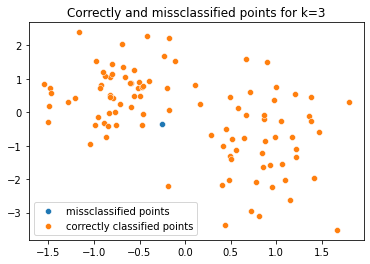

In [287]:
N = len(X)
accuracy_list = []
error_list = []
correct_points_list = []; missclassified_points_list = []

## For a given k find the missclassified points
k = 3
_, _, missclassified_points, correct_points = knn_lsh(k)

plt.title(f"Correctly and missclassified points for k={k}")
sns.scatterplot(x=missclassified_points[:,0], y=missclassified_points[:,1], label="missclassified points")
sns.scatterplot(x=correct_points[:,0], y=correct_points[:,1], label="correctly classified points")
plt.show()

In [288]:
## Knn for multiple 'k's
N = len(X)
k_values = np.arange(1,n_points,2)
accuracy_list = []
error_list = []
correct_points_list = []; missclassified_points_list = []

start = timer()
for k in k_values:
  accuracy, error, missclassified_points, correct_points = knn_lsh(k) ## LSH implementation of knn

  accuracy_list.append(accuracy)
  error_list.append(error)
  missclassified_points_list.append(missclassified_points)
  correct_points_list.append(correct_points)

stop = timer()

lsh_imple_time = stop - start 
print(f"Execution time(LSH) : {round(lsh_imple_time,2)} sec")

Execution time(LSH) : 0.89 sec


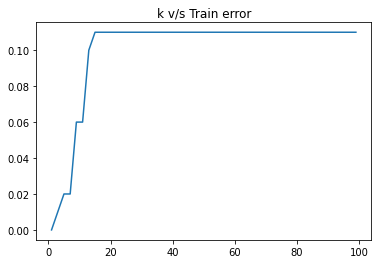

In [289]:
plt.title("k v/s Train error")
sns.lineplot(x=k_values, y=error_list)
plt.show()

In [290]:
print(f" Basic implementation execution time : {round(basic_imple_time,2)} sec\n LSH implementation execution time : {round(lsh_imple_time,2)} sec")

 Basic implementation execution time : 2.35 sec
 LSH implementation execution time : 0.89 sec
